##Acceso con cuenta de google

In [ ]:
from google.colab import auth, drive
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Instalación librería de Google Big Query

In [ ]:
pip install google-cloud-bigquery

##Carga de Librearías

In [ ]:
from google.cloud import bigquery
from google.cloud.bigquery import TableReference
import numpy as np
import pandas as pd
import shap
import sklearn as sk
import imblearn as il
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import scipy.stats as stats
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

##Conexion de BigQuery con Notebook

In [ ]:
# ID del proyecto en Google Cloud
project_id = "clear-adapter-462909-h1"

# Se crea el cliente de BigQuery usando las credenciales autenticadas
client = bigquery.Client(project=project_id)

print("Conectado.")


Conectado.


##Extracción de datos directamente de BigQuery

In [ ]:
query = """
SELECT
  fullVisitorId,
  visitStartTime,
  date,
  device.deviceCategory AS deviceCategory,
  device.isMobile AS isMobile,
  device.operatingSystem AS operatingSystem,
  device.browser AS browser,
  geoNetwork.country AS country,
  geoNetwork.city AS city,
  trafficSource.source AS trafficSource,
  trafficSource.medium AS trafficMedium,
  trafficSource.campaign AS trafficCampaign,
  totals.newVisits AS newVisits,
  totals.bounces AS bounces,
  totals.visits AS visits,
  totals.hits AS hits,
  totals.pageviews AS pageViews,
  totals.timeOnSite AS timeOnSite,
  totals.transactionRevenue as transactionRevenue,
  totals.transactions AS transactions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`

"""
df = client.query(query).to_dataframe()
df.head()


,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,newVisits,bounces,visits,hits,pageViews,timeOnSite,transactionRevenue,transactions
0,3989740855378994428,1497455649,20170614,desktop,False,Windows,Chrome,United States,San Jose,google,organic,(not set),1,<NA>,1,14,8,129,<NA>,<NA>
1,4053276322918776588,1497456388,20170614,mobile,True,Android,Chrome,Taiwan,(not set),google,organic,(not set),1,<NA>,1,14,13,641,<NA>,<NA>
2,0067566216922331849,1497476332,20170614,desktop,False,Macintosh,Chrome,United States,not available in demo dataset,(direct),(none),(not set),<NA>,<NA>,1,14,12,385,38380000,1
3,4995584940873803432,1497463936,20170614,desktop,False,Macintosh,Chrome,United States,not available in demo dataset,google,organic,(not set),<NA>,<NA>,1,14,10,168,<NA>,<NA>
4,312563032232212298,1497462978,20170614,mobile,True,Android,Chrome,United States,Santa Monica,google,organic,(not set),<NA>,<NA>,1,14,10,687,<NA>,<NA>


Extraemos mediante consulta SQL el modelo de datos inicial, limitado a datos sin N/A y hasta las 100 filas para una primera familiarización con los datos y formatos.

In [ ]:
# Dimensiones del DataFrame
print(df.shape)

# Tipos de datos
print(df.dtypes)

# Porcentaje de valores nulos por columna
print(df.isnull().mean().sort_values(ascending=False))

# Muestra aleatoria de filas
df.sample(5)

(903653, 20)
fullVisitorId          object
visitStartTime          Int64
date                   object
deviceCategory         object
isMobile              boolean
operatingSystem        object
browser                object
country                object
city                   object
trafficSource          object
trafficMedium          object
trafficCampaign        object
newVisits               Int64
bounces                 Int64
visits                  Int64
hits                    Int64
pageViews               Int64
timeOnSite              Int64
transactionRevenue      Int64
transactions            Int64
dtype: object
transactionRevenue    0.987257
transactions          0.987216
bounces               0.501324
timeOnSite            0.499925
newVisits             0.221980
pageViews             0.000111
visitStartTime        0.000000
fullVisitorId         0.000000
deviceCategory        0.000000
date                  0.000000
isMobile              0.000000
operatingSystem       0.000000
t

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,trafficMedium,trafficCampaign,newVisits,bounces,visits,hits,pageViews,timeOnSite,transactionRevenue,transactions
803185,4403620324029396556,1475719156,20161005,desktop,False,Macintosh,Chrome,United States,San Francisco,(direct),(none),(not set),1,<NA>,1,3,3,29,<NA>,<NA>
166840,6637957997898535918,1474287265,20160919,desktop,False,Windows,Chrome,United States,Salem,(direct),(none),(not set),<NA>,<NA>,1,2,2,7,<NA>,<NA>
183032,1288808094414657102,1499052437,20170702,desktop,False,Windows,Chrome,Malaysia,not available in demo dataset,(direct),(none),(not set),<NA>,1,1,1,1,<NA>,<NA>,<NA>
789828,8551747437338740409,1479595524,20161119,desktop,False,Macintosh,Chrome,Ireland,Dublin,(direct),(none),(not set),1,1,1,1,1,<NA>,<NA>,<NA>
72503,3475041499292278065,1486147733,20170203,tablet,True,Android,Chrome,India,not available in demo dataset,(direct),(none),(not set),1,<NA>,1,2,2,45,<NA>,<NA>


Altos porcentajes de valores nulos en las columnas transactions y transactionRevenue indican que la mayoría de las filas no tienen datos sobre transacciones o ingresos de transacciones. Esto puede ser debido a que muchas visitas no resultan en una compra.
Columnas como bounces y timeOnSite también tienen una cantidad significativa de valores nulos, lo que sugiere que hay muchas visitas donde estos datos no se registran.
Columnas con valores nulos bajos o nulos (pageviews, isMobile, operatingSystem, etc.) indican que estos datos están casi siempre presentes y pueden ser más confiables para el análisis.

##Selección del periodo temporal

####Número de sesiones por mes

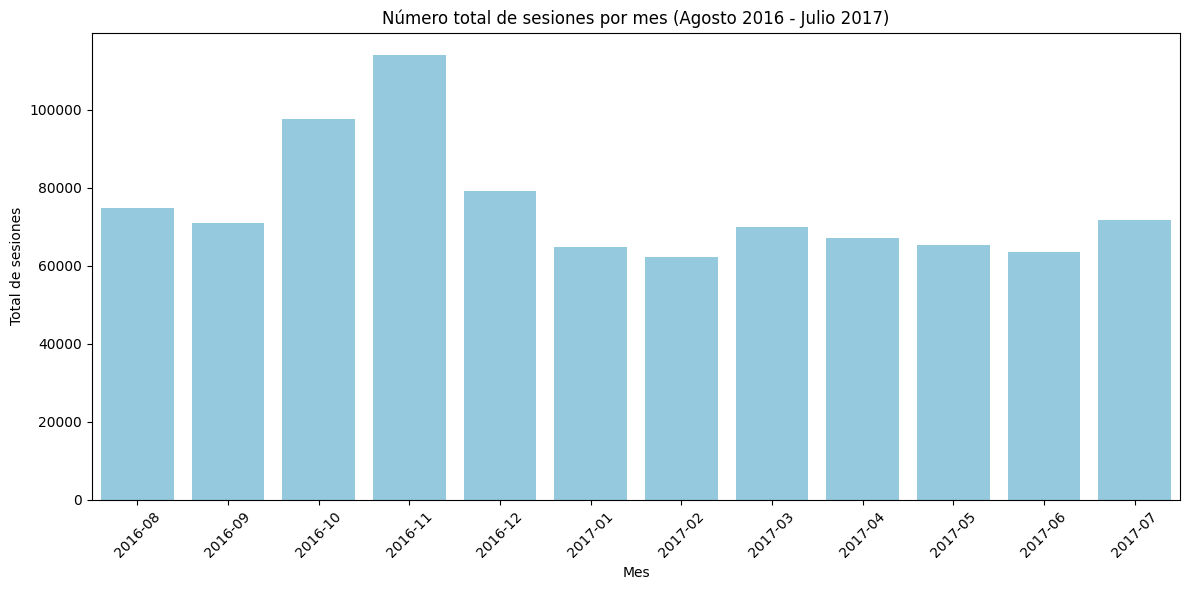

In [ ]:
#Obtenemos el número de sesiones por mes para ver cómo varía el tráfico a lo largo del año:

query_sesiones_totales = """
SELECT
  FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS month,
  COUNT(*) AS total_sessions
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY month
ORDER BY month
"""
df_sesiones_totales = client.query(query_sesiones_totales).to_dataframe()
df_sesiones_totales.head()

#Convierte la fecha de cada sesión al formato "año-mes" (por ejemplo: 2016-09).
#Cuenta cuántas sesiones hay en cada mes.
#Agrupa por mes y ordena de forma cronológica.

# Gráfico con Seaborn + Matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sesiones_totales, x='month', y='total_sessions', color='skyblue')
plt.xticks(rotation=45)
plt.title("Número total de sesiones por mes (Agosto 2016 - Julio 2017)")
plt.xlabel("Mes")
plt.ylabel("Total de sesiones")
plt.tight_layout()
plt.show()


####Sesiones convertidas por mes

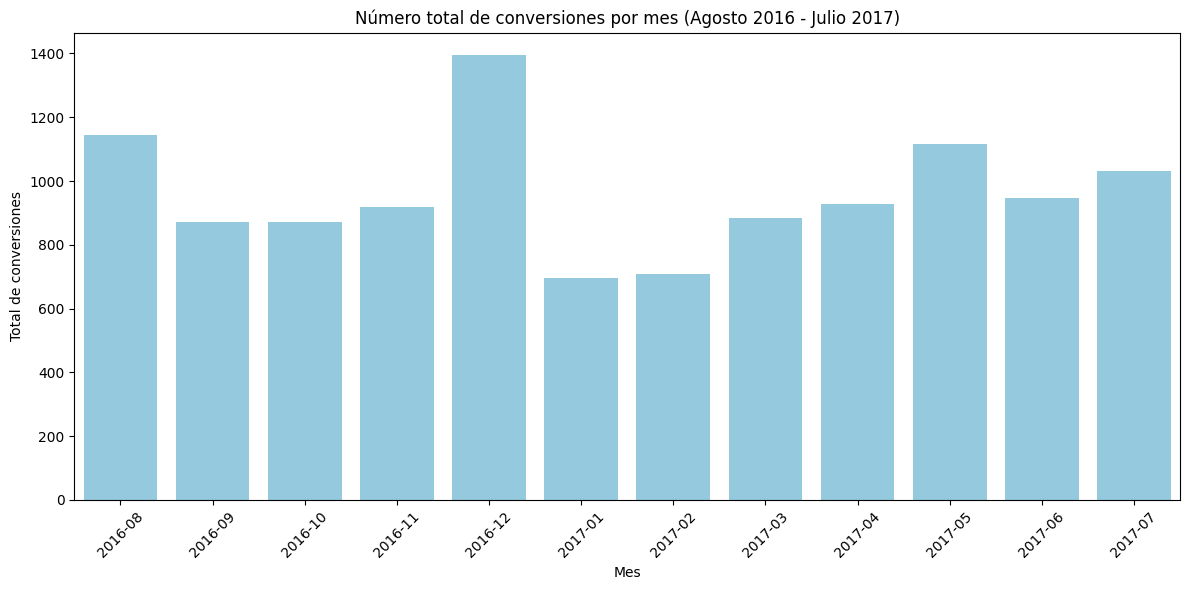

In [ ]:
query_convertidas = """
SELECT
  FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', date)) AS month,
  COUNTIF(totals.transactions IS NOT NULL AND totals.transactions > 0) AS conversiones
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY month
ORDER BY month
"""
df_sesiones_convertidas = client.query(query_convertidas).to_dataframe()
df_sesiones_convertidas.head()

#Convierte la fecha de cada sesión al formato "año-mes" (por ejemplo: 2016-09).
#Cuenta cuántas sesiones hay en cada mes.
#Agrupa por mes y ordena de forma cronológica.

# Gráfico con Seaborn + Matplotlib
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sesiones_convertidas, x='month', y='conversiones', color='skyblue')
plt.xticks(rotation=45)
plt.title("Número total de conversiones por mes (Agosto 2016 - Julio 2017)")
plt.xlabel("Mes")
plt.ylabel("Total de conversiones")
plt.tight_layout()
plt.show()

      month  total_sessions  conversiones  conversion_rate
0   2016-08           74759          1145         0.015316
1   2016-09           71032           870         0.012248
2   2016-10           97506           872         0.008943
3   2016-11          113972           919         0.008063
4   2016-12           79124          1395         0.017631
5   2017-01           64694           697         0.010774
6   2017-02           62192           708         0.011384
7   2017-03           69931           883         0.012627
8   2017-04           67126           928         0.013825
9   2017-05           65371          1115         0.017056
10  2017-06           63578           946         0.014879
11  2017-07           71812          1031         0.014357


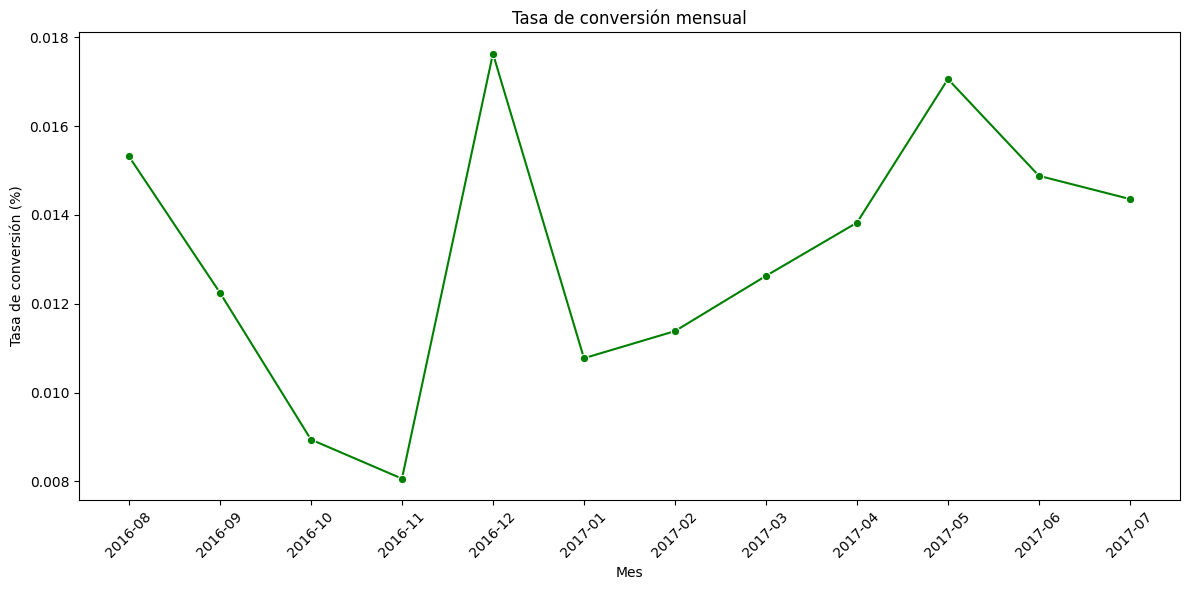

In [ ]:
# Unir con el DataFrame anterior
df_monthly = df_sesiones_totales.merge(df_sesiones_convertidas, on='month')

# Calcular tasa de conversión mensual
df_monthly['conversion_rate'] = df_monthly['conversiones'] / df_monthly['total_sessions']

# Ver tabla
print(df_monthly)

#Visualización combinada
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_monthly, x='month', y='conversion_rate', marker='o', color='green')
plt.xticks(rotation=45)
plt.title("Tasa de conversión mensual")
plt.ylabel("Tasa de conversión (%)")
plt.xlabel("Mes")
plt.tight_layout()
plt.show()


Extraemos de nuevo los datos pero sólo para el periodo seleccionado, es decir, de abril a junio del 2017. Aprovechamos para añadir en este paso y preivo a la limpieza dos variables addedToCart,  productoPagesViewed, que se explican en el partado de ingeniería de variables.

In [ ]:
query = """
WITH session_data AS (
  SELECT
  fullVisitorId,
  visitStartTime,
  date,
  device.deviceCategory AS deviceCategory,
  device.isMobile AS isMobile,
  device.operatingSystem AS operatingSystem,
  device.browser AS browser,
  geoNetwork.country AS country,
  geoNetwork.city AS city,
  trafficSource.source AS trafficSource,
  trafficSource.medium AS trafficMedium,
  trafficSource.campaign AS trafficCampaign,
  totals.newVisits AS newVisits,
  totals.bounces AS bounces,
  totals.visits AS visits,
  totals.hits AS hits,
  totals.pageviews AS pageViews,
  totals.timeOnSite AS timeOnSite,
  totals.transactionRevenue as transactionRevenue,
  totals.transactions AS transactions,
  hits AS hit_array
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160925' AND '20161001'
)

SELECT
  fullVisitorId,
  visitStartTime,
  date,
  deviceCategory,
  isMobile,
  operatingSystem,
  browser,
  country,
  city,
  trafficSource,
  trafficMedium,
  trafficCampaign,
  newVisits,
  bounces,
  visits,
  hits,
  pageViews,
  timeOnSite,
  transactionRevenue,
  transactions,
  SUM(IF(hit.page.pagePath LIKE '/google+redesign/%', 1, 0)) AS productPagesViewed,
  SUM(IF(hit.type = 'EVENT' AND hit.eventInfo.eventAction = 'Add to Cart', 1, 0)) AS addedToCart
FROM
  session_data,
  UNNEST(hit_array) AS hit
GROUP BY
  fullVisitorId,
  visitStartTime,
  date,
  deviceCategory,
  isMobile,
  operatingSystem,
  browser,
  country,
  city,
  trafficSource,
  trafficMedium,
  trafficCampaign,
  newVisits,
  bounces,
  visits,
  hits,
  pageViews,
  timeOnSite,
  transactionRevenue,
  transactions
"""
df = client.query(query).to_dataframe()
df.head()

,fullVisitorId,visitStartTime,date,deviceCategory,isMobile,operatingSystem,browser,country,city,trafficSource,...,newVisits,bounces,visits,hits,pageViews,timeOnSite,transactionRevenue,transactions,productPagesViewed,addedToCart
0,4077971351037489785,1475000587,20160927,desktop,False,Windows,Chrome,United States,San Jose,(direct),...,<NA>,1,1,1,1,<NA>,<NA>,<NA>,1,0
1,0433717850654724060,1474965857,20160927,desktop,False,Windows,Chrome,Germany,not available in demo dataset,analytics.google.com,...,<NA>,1,1,1,1,<NA>,<NA>,<NA>,1,0
2,8596650678185412240,1475031455,20160927,mobile,True,iOS,Chrome,United States,not available in demo dataset,(direct),...,<NA>,1,1,1,1,<NA>,<NA>,<NA>,1,0
3,3157455721745052446,1474987745,20160927,desktop,False,Windows,Chrome,Netherlands,not available in demo dataset,(direct),...,<NA>,1,1,1,1,<NA>,<NA>,<NA>,1,0
4,5152102660566456119,1474964790,20160927,tablet,True,iOS,Chrome,France,not available in demo dataset,(direct),...,<NA>,1,1,1,1,<NA>,<NA>,<NA>,1,0


##Limpieza inicial del dataset

a) Análisis y corrección de valores nulos

In [ ]:
# Calcular % de nulos por variable
(df.isnull().sum() / len(df)).sort_values(ascending=False) * 100

,0
transactions,98.799073
transactionRevenue,98.799073
bounces,51.255791
timeOnSite,48.841746
newVisits,22.006828
pageViews,0.006096
operatingSystem,0.000000
isMobile,0.000000
deviceCategory,0.000000
date,0.000000


In [ ]:
# Imputar valores nulos con 0
cols_to_fill = ['transactionRevenue', 'transactions', 'bounces', 'timeOnSite', 'newVisits']
df[cols_to_fill] = df[cols_to_fill].fillna(0)

#La variable pageviews, con un porcentaje de nulos muy bajo, fue imputada también con 0 por simplicidad.
df['pageViews'] = df['pageViews'].fillna(0)


b) Ajuste de los tipos de datos

In [ ]:
# Convertir timestamps a datetime
#visitStartTime → de timestamp a formato fecha legible.
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], unit='s')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

c) Eliminación de duplicados

In [ ]:
# Comprobar duplicados
duplicates = df.duplicated(subset=['fullVisitorId', 'visitStartTime', 'date'])
print(f"Registros duplicados: {duplicates.sum()}")


Registros duplicados: 0


d) Validación de coherencia lógica

In [ ]:
# Verificar inconsistencias
inconsistencias_trx = df[(df['transactions'] == 0) & (df['transactionRevenue'] > 0)]
print(f"Inconsistencias entre transacciones y revenue: {len(inconsistencias_trx)}")

inconsistencias_hits = df[(df['hits'] == 0) & (df['pageViews'] > 0)]
print(f"Inconsistencias entre hits y pageviews: {len(inconsistencias_hits)}")


Inconsistencias entre transacciones y revenue: 0
Inconsistencias entre hits y pageviews: 0


Se mantuvieron 16404 registros originales.

Los nulos fueron imputados lógicamente sin perder información.

Las variables están listas para ser utilizadas en modelos predictivos o para ser transformadas en nuevas variables.


e) Tratamiento de valores atípicos

Realizamos el estudio y tratamiento de outliers mediante el rango intercuartílico.

Comentarios valores atípicos:
Para detectar valores atípicos, se ha aplicado el criterio clásico del rango intercuartílico (IQR): e consideran atípicos los valores que están por debajo de Q1 - 1.5×IQR o por encima de Q3 + 1.5×IQR, donde Q1 y Q3 son el primer y tercer cuartil respectivamente.


Outliers detectados en transactionRevenue: 197


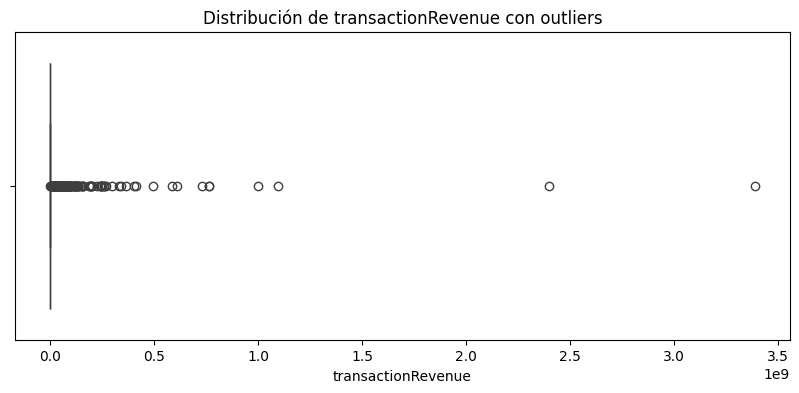

In [ ]:
# Variable a analizar
var = 'transactionRevenue'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Se observan valores extremos muy altos, incluyendo algunos con ingresos de más de 20.000 millones de micros (es decir, más de 20.000 dólares).

Estos valores corresponden a sesiones de compra reales, por lo que no se eliminan, sino que se les aplicará una transformación logarítmica para reducir su efecto.

Outliers detectados en timeOnSite: 2277


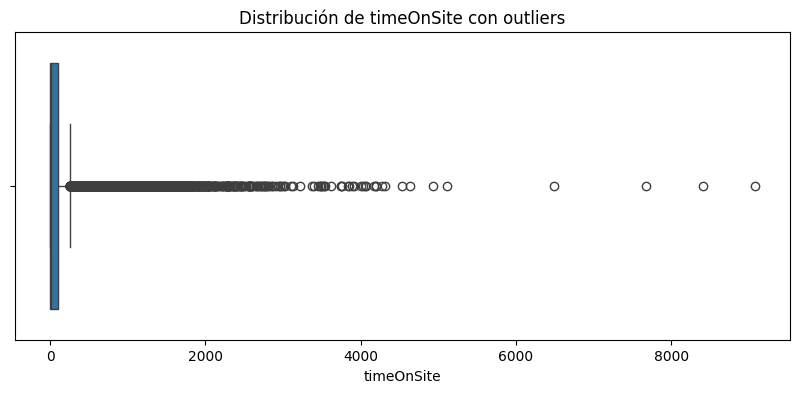

In [ ]:
# Variable a analizar
var = 'timeOnSite'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Outliers detectados en addedToCart: 996


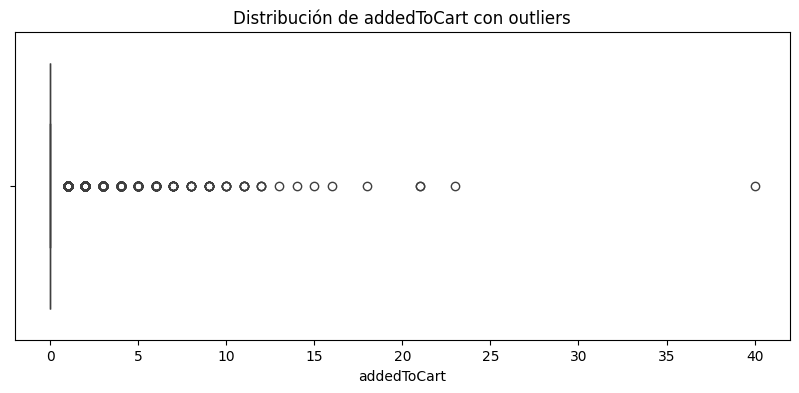

In [ ]:
# Variable a analizar
var = 'addedToCart'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Outliers detectados en productPagesViewed: 2535


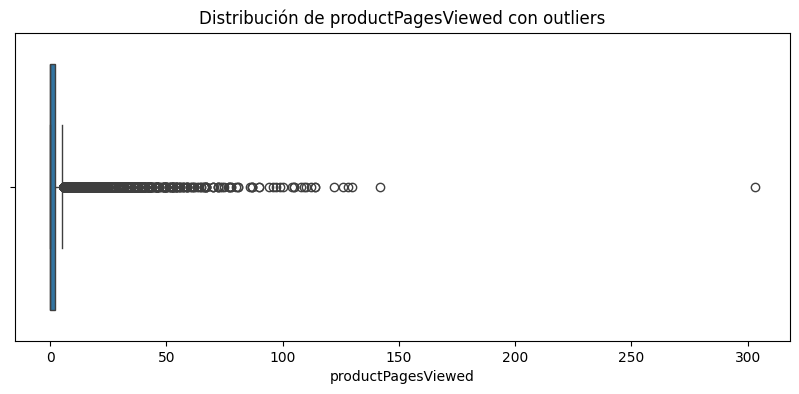

In [ ]:
# Variable a analizar
var = 'productPagesViewed'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Outliers detectados en pageViews: 2268


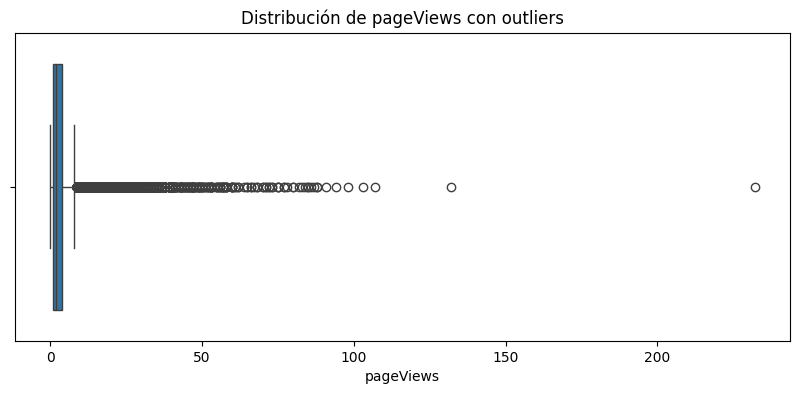

In [ ]:
# Variable a analizar
var = 'pageViews'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Outliers detectados en hits: 2103


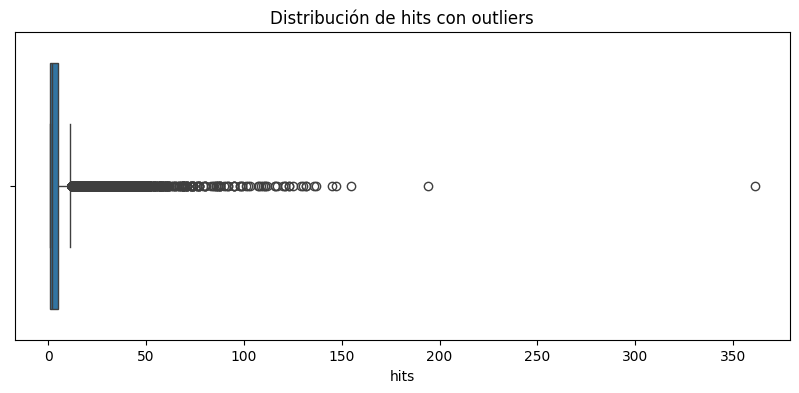

In [ ]:
# Variable a analizar
var = 'hits'

# Calcular IQR
Q1 = df[var].quantile(0.25)
Q3 = df[var].quantile(0.75)
IQR = Q3 - Q1

# Límites para considerar outliers
Limite_inferior = Q1 - 1.5 * IQR
Limite_superior = Q3 + 1.5 * IQR

# Contar valores atípicos
outliers = df[(df[var] > Limite_superior) | (df[var] < Limite_inferior)]
print(f"Outliers detectados en {var}: {len(outliers)}")

# Visualización
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[var])
plt.title(f'Distribución de {var} con outliers')
plt.show()

Ambas variables presentan distribuciones fuertemente asimétricas, con sesiones que superan las 200 páginas vistas o más de 350 interacciones en una sola sesión.

Dado que estos valores pueden reflejar conductas anómalas o bots, se decidió aplicar un recorte en el percentil 99 para evitar que distorsionen los modelos (Razones de uso del percentil 99).

Se ha optado por truncar las variables pageviews y hits al percentil 99 porque:

Reducen el efecto de valores extremos en el modelo.

Permiten conservar el 99% del comportamiento del usuario real.

Los valores por encima de ese umbral son escasos y atípicos.

Existe sospecha razonable de que representan comportamientos no humanos o errores técnicos.

Por tanto, a partir del análisis anterior se aplican los siguentes ajustes:

In [ ]:
#Conversión de las variables transactionTevenue y timeOnSite a logarítmicas para suavizar su comportamiento sin perder infomración:
# Evitamos log(0) con log1p
df['logRevenue'] = np.log1p(df['transactionRevenue'])
df['logTimeOnSite'] = np.log1p(df['timeOnSite'])


In [ ]:
#Recormatos las variables pageViews y hits en el percentil 99 para quitar los datos más extremos:
for var in ['pageViews', 'hits']:
    upper = df[var].quantile(0.99)
    df.loc[df[var] > upper, var] = upper

#Recormatos las variables addedToCart y productPagesViewed en el percentil 99 para quitar los datos más extremos:
for col in ['productPagesViewed', 'addedToCart']:
    threshold = df[col].quantile(0.99)
    df.loc[df[col] > threshold, col] = threshold


  ##Ingeniería de variables y enriquecimiento del DataSet

A través del dataset disponible y tras investiagaciones sobre cómo obtener la información más compelta posible para nuestro modelo, procedemos en este paso a la adición de nuevas variables desde la información disponible. En este apartado, además de replicar algunas de las variables ya disponibles en Kaggle se añaden otras que creemos pueden ser de interés para nuestro modelo.

1.   addedToCart,  productoPagesViewed

La adición de estas dos variables debe realizarse directamente desde BigQuery mediante la sentencia UNNEST, pues la información a extraer se encuentra dentro de la variable hits del dataset. El dataset tiene una estructura jerárquica, donde cada fila es una sesión, pero dentro de cada sesión están los hits, por lo que obtener esa información desde el dataframe sería más costoso e ineficiente.



2.   isFirstVisit

Indica si se trata de la primera visita del usuario. Esta información es útil para entender el comportamiento de nuevos usuarios frente a recurrentes, lo que puede influir significativamente en la probabilidad de conversión. Para su cálculo, la obtenemos desde newVisits. Si dicha variable es igual a 1, le daremos el valor de primera visita.

In [ ]:
df['isFirstVisit'] = df['newVisits'].fillna(0).astype(int).apply(lambda x: 1 if x == 1 else 0)


3.   isBounce

Identifica sesiones en las que el usuario solo visitó una página antes de abandonar el sitio. Esta métrica es un fuerte indicador de desinterés o mala experiencia de usuario (primer paso del embudo de conversión) e importante no sólo para el modelo sino también para las estraetegias de marketing digital. La obtenemos desde bounces, donde si el valor de esta es igual a 1, consideramos que ha sido rebote.

In [ ]:
df['isBounce'] = df['bounces'].fillna(0).astype(int).apply(lambda x: 1 if x == 1 else 0)

4.   pagesPerSession

Esta variable va a representar el número medio de páginas vistas por sesión, lo que creemos que es especialmente relevante de cara a convertir. Se obtiene mediante la divisón de totalPageviews y total visits.

In [ ]:
df['pagesPerSession'] = df['pageViews'].astype(float) / df['visits'].astype(float)
df['pagesPerSession'] = df['pagesPerSession'].fillna(0)


5. timePerPage

Es el tiempo medio dedicado por página. Sin duda, un buen indicador para determinar el interés del usuario por el contenido de la página. Se obtiene de dividir el totalTimeOnSite entre totalPageviews.

In [ ]:
df['timePerPage'] = df['timeOnSite'].astype(float) / df['pageViews'].astype(float)
df['timePerPage'] = df['timePerPage'].fillna(0)


6. madePurchase

Variable binaria que indica si hubo al menos una transacción. Una variable fundamental para definir nuestra variable objetivo en el modelo. Si el número de transacciones es mayor a 0 le asignamos el valor de 1, si no, 0.

In [ ]:
df['madePurchase'] = df['transactions'].fillna(0).astype(int).apply(lambda x: 1 if x > 0 else 0)


7. revenuePerHit

Muestra el ingreso medio generado por cada hit (interacción) del usuario durante una sesión. Se calcula dividiendo el revenue total de la sesión por el número de hits. Esta variable nos ayuda a detectar sesiones en las que cada interacción ha generado más ingresos, lo que podría significar que el usuario ha tenido un comportamiento más eficiente o una mayor intención de compra. Por eso, se considera que puede ser una variable interesante para el modelo y para una posible clasificación de usuarios según su valor potencial.

In [ ]:
df['revenuePerHit'] = df['transactionRevenue'] / df['hits']
df['revenuePerHit'] = df['revenuePerHit'].replace([np.inf, -np.inf], 0).fillna(0)

8. revenuePerPageView

Muestra el ingreso medio generado por cada página vista en una sesión. Se obtiene dividiendo el revenue total por el número de páginas vistas (pageviews). Permite analizar la monetización del contenido. Por ejemplo, si una sesión tiene pocas páginas vistas pero un alto valor de revenue, el valor de revenuePerPageview será alto, lo que puede interpretarse como una navegación más directa hacia la conversión. Por el contrario, un valor bajo podría indicar que el usuario ha navegado mucho sin realizar una compra significativa, o incluso sin comprar. Se añade esta variable ya que permite entender mejor el comportamiento de los usuarios en relación con el contenido del sitio.

In [ ]:
df['revenuePerPageView'] = df.apply(
    lambda row: row['transactionRevenue'] / row['pageViews'] if row['pageViews'] > 0 else 0,
    axis=1
)


##Exploración de datos (EDA)

Resumen general del dataset

In [ ]:
# Tamaño del dataset
print(df.shape)

# Primeras filas
df.head()

# Información general
df.info()


# Número de valores nulos por columna
df.isnull().sum()

# Estadísticas descriptivas para columnas numéricas
df.describe()

NameError: name 'df' is not defined

Análisis univariable variables categóricas

In [ ]:
categorical_vars = [
    'deviceCategory', 'isMobile', 'operatingSystem', 'browser', 'country',
    'city', 'trafficSource', 'trafficMedium', 'trafficCampaign'
]

# Conteo de frecuencias y gráficos de barras
for var in categorical_vars:
    plt.figure(figsize=(10, 4))
    df[var].value_counts(normalize=True).head(10).plot(kind='bar', color='coral')
    plt.title(f'Distribución de {var} (Top 10)')
    plt.ylabel('% de observaciones')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Análisis univariante variables numéricas

In [ ]:
num_cols =   [
    'hits', 'pageViews', 'timeOnSite', 'transactionRevenue', 'transactions',
    'productPagesViewed', 'addedToCart', 'logRevenue', 'logTimeOnSite',
    'pagesPerSession', 'timePerPage', 'revenuePerHit', 'revenuePerPageView']


# Histograma de cada variable
df[num_cols].hist(bins=20, figsize=(14, 8))
plt.tight_layout()
plt.show()



NameError: name 'df' is not defined

Análisis univarianta variable objetivo

In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x='madePurchase', data=df, palette='pastel')
plt.title('Distribución de la variable objetivo')
plt.xticks([0, 1], ['No compra', 'Compra'])
plt.ylabel('Número de sesiones')
plt.xlabel('¿Se realizó una compra?')
plt.tight_layout()
plt.show()

# Porcentaje de compradores vs no compradores
purchase_rate = df['madePurchase'].value_counts(normalize=True) * 100
print(purchase_rate)

###Análsis bivarainte variables categóricas VS madePurchase

In [ ]:
categorical_vars = [
    'deviceCategory', 'isMobile', 'operatingSystem', 'browser',
    'country', 'city', 'trafficSource', 'trafficMedium', 'trafficCampaign'
]

# Función para graficar proporciones de compra por categoría
for var in categorical_vars:
    conversion_by_category = df.groupby(var)['madePurchase'].mean().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=conversion_by_category.index, y=conversion_by_category.values, palette='viridis')
    plt.title(f'Tasa de conversión según {var} (Top 10)')
    plt.ylabel('Tasa de conversión (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

###Análisis bivarainte variables numéricas VS madePurchase

In [ ]:
# Lista de variables numéricas
numerical_vars = [
    'hits', 'pageViews', 'timeOnSite', 'transactionRevenue',
    'transactions', 'productPagesViewed', 'addedToCart',
    'logRevenue', 'logTimeOnSite', 'pagesPerSession',
    'timePerPage', 'revenuePerHit', 'revenuePerPageView'
]

# Boxplots comparativos entre compradores y no compradores
for var in numerical_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='madePurchase', y=var, data=df, palette='Set2')
    plt.title(f'{var} según si se realizó compra')
    plt.xticks([0, 1], ['No compra', 'Compra'])
    plt.ylabel(var)
    plt.tight_layout()
    plt.show()


NameError: name 'plt' is not defined

c) Correlación entre variables

In [ ]:

# Selección de variables numéricas relevantes para el modelo
numeric_vars = [
    'hits',
    'pageViews',
    'productPagesViewed',
    'logTimeOnSite',
    'pagesPerSession',
    'timePerPage',
    'addedToCart'
]

# Cálculo de la matriz de correlaciones (coeficiente de Pearson por defecto)
correlation_matrix = df[numeric_vars].corr(method='pearson')

# Visualización con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Matriz de correlaciones entre variables numéricas')
plt.show()


In [ ]:
# Descomponer la matriz en pares ordenados
corr_pairs = correlation_matrix.unstack()

# Eliminar duplicados y correlaciones de una variable consigo misma
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates().sort_values(key=lambda x: abs(x), ascending=False)

# Convertir a DataFrame
corr_table = corr_pairs.reset_index()
corr_table.columns = ['Variable 1', 'Variable 2', 'Correlación']
print(corr_table)

##Entrenamiento Modelo


Preparar los datos

In [ ]:
# 1. Variable objetivo
y = df["madePurchase"]

# 2. Ver correlaciones con variable objetivo
correlaciones = df.corr(numeric_only=True)["madePurchase"].sort_values(ascending=False)
print(correlaciones)

# 2. Eliminar columnas irrelevantes
X = df.drop(columns=["madePurchase", "fullVisitorId", "visitStartTime", "date","transactions", "logRevenue", "transactionRevenue", "revenuePerHit", "revenuePerPageView"])

# 3. Detectar y codificar columnas categóricas y booleanas
cat_cols = [
    "deviceCategory", "operatingSystem", "browser", "country", "city",
    "trafficSource", "trafficMedium", "trafficCampaign"]

bool_cols = ["isMobile", "isFirstVisit", "isBounce"]
cols_to_encode = cat_cols + bool_cols

X = pd.get_dummies(X, columns=cols_to_encode, drop_first=True)

# 4. Verificar que quedó bien
print(X.shape)
X.head()


madePurchase          1.000000
logRevenue            0.997517
transactions          0.953457
addedToCart           0.424516
revenuePerPageView    0.401190
transactionRevenue    0.382222
revenuePerHit         0.366864
pagesPerSession       0.345269
pageViews             0.345269
hits                  0.333452
timeOnSite            0.250533
productPagesViewed    0.226953
logTimeOnSite         0.184113
timePerPage           0.039755
isMobile             -0.039303
isFirstVisit         -0.102187
newVisits            -0.102187
bounces              -0.107516
isBounce             -0.107516
visits                     NaN
Name: madePurchase, dtype: float64
(16404, 390)


,newVisits,bounces,visits,hits,pageViews,timeOnSite,productPagesViewed,addedToCart,logTimeOnSite,pagesPerSession,...,trafficMedium_affiliate,trafficMedium_cpc,trafficMedium_cpm,trafficMedium_organic,trafficMedium_referral,trafficCampaign_AW - Dynamic Search Ads Whole Site,trafficCampaign_Data Share Promo,isMobile_True,isFirstVisit_1,isBounce_1
0,0,1,1,1,1,0,1,0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
1,0,1,1,1,1,0,1,0,0.0,1.0,...,False,False,False,False,True,False,False,False,False,True
2,0,1,1,1,1,0,1,0,0.0,1.0,...,False,False,False,False,False,False,False,True,False,True
3,0,1,1,1,1,0,1,0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,True
4,0,1,1,1,1,0,1,0,0.0,1.0,...,False,False,False,False,False,False,False,True,False,True


Dividir el dataset y manejar el desbalance de clases

In [ ]:
# 1. Tomar una muestra
X_sample = X.copy()
y_sample = y.copy()

# 2. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

print("Distribución en y_train antes del balanceo:")
print(y_train.value_counts(normalize=True))

# 3. Rellenar valores nulos si existen
X_train = X_train.fillna(0).astype(float)

# 4. Aplicar RandomUnderSampler para balancear reduciendo la clase mayoritaria
rus = RandomUnderSampler(random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

print("Distribución en y_train después de UnderSampling:")
print(y_train_bal.value_counts(normalize=True))




Distribución en y_train antes del balanceo:
madePurchase
0    0.98796
1    0.01204
Name: proportion, dtype: float64
Distribución en y_train después de UnderSampling:
madePurchase
0    0.5
1    0.5
Name: proportion, dtype: float64


Entrenar modelo

In [ ]:
# RandomForest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train_bal, y_train_bal)
y_pred_rf = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]

# XGBoost
modelo_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
modelo_xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = modelo_xgb.predict(X_test)
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

# Logistic Regression (con datos originales pero balanceo por pesos)
modelo_lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
modelo_lr.fit(X_train, y_train)
y_pred_lr = modelo_lr.predict(X_test)
y_proba_lr = modelo_lr.predict_proba(X_test)[:, 1]

# --------------------------------------------
# FUNCIÓN DE EVALUACIÓN
# --------------------------------------------
def evaluar_modelo(nombre, y_test, y_pred, y_proba):
    print(f"\n🔍 Reporte de clasificación - {nombre}")
    print(classification_report(y_test, y_pred))
    print(f"AUC - {nombre}: {roc_auc_score(y_test, y_proba):.4f}")

evaluar_modelo("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluar_modelo("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
evaluar_modelo("Logistic Regression", y_test, y_pred_lr, y_proba_lr)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:38:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔍 Reporte de clasificación - Random Forest
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      3242
           1       0.11      1.00      0.20        39

    accuracy                           0.90      3281
   macro avg       0.55      0.95      0.57      3281
weighted avg       0.99      0.90      0.94      3281

AUC - Random Forest: 0.9877

🔍 Reporte de clasificación - XGBoost
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3242
           1       0.21      1.00      0.35        39

    accuracy                           0.96      3281
   macro avg       0.61      0.98      0.67      3281
weighted avg       0.99      0.96      0.97      3281

AUC - XGBoost: 0.9886

🔍 Reporte de clasificación - Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3242
           1       0.27      0.95      0.43        39



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de confusión de cada modelo

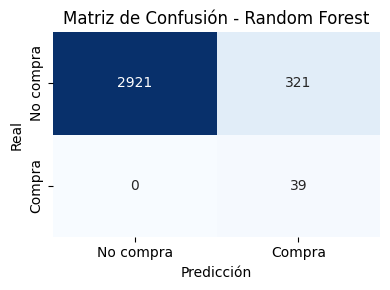

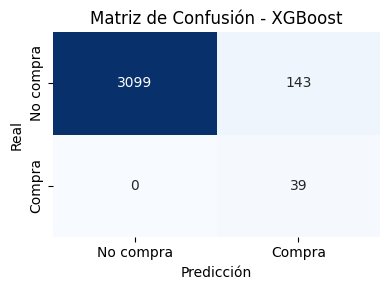

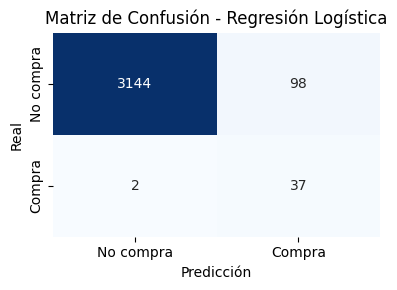

In [ ]:

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No compra", "Compra"],
                yticklabels=["No compra", "Compra"])
    plt.title(f"Matriz de Confusión - {title}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

# Llama a la función para cada modelo
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
plot_confusion_matrix(y_test, y_pred_lr, "Regresión Logística")



Resultados del modelo elegido XG-Boost

In [ ]:
# Predicciones binarias
y_pred = modelo_xgb.predict(X_test)

# Probabilidades de conversión
y_proba = modelo_xgb.predict_proba(X_test)[:, 1]

# Tabla de resultados
import pandas as pd
results = pd.DataFrame({
    'y_real': y_test,
    'y_pred': y_pred,
    'prob_compra': y_proba
})
results.head(100)



,y_real,y_pred,prob_compra
5168,0,0,0.000925
15510,0,0,0.000906
986,0,0,0.000925
13859,1,1,0.987822
8772,0,0,0.001101
...,...,...,...
2752,0,0,0.000925
1237,0,0,0.006157
9297,0,0,0.000815
9009,0,0,0.001184


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results)

https://docs.google.com/spreadsheets/d/1-cttOTEzJb84aDPEoa5SVdhOhmzibkqhWFi00-ogirs/edit#gid=0


Segmentación de clientes y potencial de compra

In [ ]:
# 1. Predecir sobre TODO X
y_proba_total = modelo_xgb.predict_proba(X)[:, 1]

# 2. Copiar df original
df_resultados = df.copy()

# 3. Asignar probabilidad de compra
df_resultados['probabilidad_compra'] = y_proba_total

# 4. Asignar segmento según probabilidad
def segmentar(prob):
    if prob >= 0.75:
        return "Campaña Fuerte"
    elif prob >= 0.4:
        return "Campaña Moderada"
    else:
        return "Campaña Suave"

df_resultados['segmento_campaña'] = df_resultados['probabilidad_compra'].apply(segmentar)

# 5. Exportar todo a Excel
df_resultados.to_excel("/content/drive/MyDrive/TFM/segmentacion_completa.xlsx", index=False)
df_resultados[['probabilidad_compra', 'segmento_campaña']].head()


,probabilidad_compra,segmento_campaña
0,0.003456,Campaña Suave
1,0.002906,Campaña Suave
2,0.004662,Campaña Suave
3,0.002906,Campaña Suave
4,0.003921,Campaña Suave
